# **Magic: The Gathering Multiple Card Detection**  
## **Building an Optimized Computer Vision Pipeline for OCR**  

### **Author:** Carlos Hernán Guirao  
### **Date:** 2025-02-26  

---

### **Overview**  

This notebook documents the development and evaluation of a computer vision pipeline for detecting and extracting multiple Magic: The Gathering cards from a frame. The primary objective is to optimize preprocessing techniques to enhance Optical Character Recognition (OCR) accuracy, ensuring reliable extraction of card names.  

### **Key Focus Areas**  

1. **Multi-Card Detection** – Identifying and segmenting multiple cards in an image using contour detection, edge detection, or deep learning-based methods.  
2. **Preprocessing for OCR** – Enhancing image quality through geometric transformations, noise reduction, and contrast adjustments.  
3. **OCR Accuracy Evaluation** – Testing OCR models on extracted card names and comparing performance across different preprocessing techniques.  

The insights gained from this notebook will contribute to refining the card scanning capabilities of the *Magic Lens* application, ensuring efficient and precise recognition of Magic: The Gathering cards.  

---

## **Scope of This Notebook**  

This notebook focuses exclusively on **the OCR process for extracting card names**. Advanced features such as **card version differentiation** and **real-time multi-card processing** will be addressed in future iterations.  

---

## **Goal Description**  

In real-world conditions, Magic: The Gathering cards may appear in images or videos alongside various background elements such as playmats, tables, hands, and other objects—including overlapping cards. The goal of this case study is to evaluate how effectively the detection pipeline can identify cards while filtering out distractions, ensuring accurate OCR-based name extraction from multiple input sources, including live webcam feeds, recorded videos, and static images.  

### **Scenario Description**  
_(Illustration: A frame containing multiple cards alongside other objects)_  

A given frame—whether from a webcam, a video, or a static image—contains multiple Magic: The Gathering cards placed on a surface, with additional non-card objects in the scene. The system must:  

1. **Detect all visible cards**, filtering out irrelevant elements (e.g., dice, tokens, hands, playmats).  
2. **Isolate each card individually** using image segmentation techniques.  
3. **Preprocess detected cards** to enhance readability for OCR.  
4. **Extract card names with high accuracy**, minimizing recognition errors.  

### **Challenges Addressed**  

- **Lighting Variability** – Managing uneven lighting, glare, and shadows affecting card visibility.  
- **Perspective Distortion** – Handling tilted or partially occluded cards to maintain accurate recognition.  
- **Overlapping Cards** – Resolving cases where multiple cards partially cover one another.  
- **Object Differentiation** – Preventing non-card elements from interfering with detection and OCR.  

### **Expected Outcome**  

This case study aims to evaluate the system’s ability to distinguish Magic: The Gathering cards from other objects and ensure high-accuracy OCR extraction of card names. The findings will guide further refinements to improve robustness, precision, and efficiency in real-world scanning scenarios.

---

In [1]:
import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# root
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils import *

## 1. Multiple Card Detection

In [2]:
def find_cards(model_image, input_image, preprocess, method, visualize, save_path):
    target_img, found, found_original = method(model_image, input_image, preprocess, visualize, save_path)

    return target_img, found, found_original

## 2. Card Name Extraction

In [3]:
import cv2 as cv
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

def order_corners(pts):
    """
    Given 4 corner points, sort them in the order:
      [top-left, top-right, bottom-right, bottom-left].
    """
    pts = pts.reshape(4, 2)
    sorted_y = pts[np.argsort(pts[:, 1]), :]
    top_two = sorted_y[:2]
    bottom_two = sorted_y[2:]
    # sort each pair by x-coordinate
    top_left, top_right = top_two[np.argsort(top_two[:, 0])]
    bottom_left, bottom_right = bottom_two[np.argsort(bottom_two[:, 0])]
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")


def approx_and_warp_card(original_image, contour):
    """
    Approximate contour to 4 corners and apply a perspective transform
    to get a straight-on view of the card. If not exactly 4 corners,
    fallback to using minAreaRect for partial/overlapping cards.
    Returns the warped image or None.
    """
    perimeter = cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, 0.02 * perimeter, True)

    if len(approx) == 4:
        # --- Original approach with 4 corners ---
        rect = order_corners(approx)
    else:
        # --- Fallback: use minAreaRect for partial/overlapped cards ---
        # This gives us a rotated bounding rectangle with 4 corner points.
        rect_min_area = cv.minAreaRect(contour)
        box = cv.boxPoints(rect_min_area)
        box = box.astype(int)
        rect = order_corners(box)

    (tl, tr, br, bl) = rect

    widthA  = np.linalg.norm(br - bl)
    widthB  = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Avoid zero-size warps
    if maxWidth < 5 or maxHeight < 5:
        return None

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(original_image, M, (maxWidth, maxHeight))

    return warped


def extract_card_name(image, ocr_preprocess, visualize=False):
    """
    Extract text from the provided card name region image using Tesseract.
    Optionally visualize the processed (thresholded) image and return it.
    """
    processed = ocr_preprocess(image)

    # OCR configuration; adjust as needed
    config = (
        '--dpi 96 --psm 6 '
        '-c preserve_interword_spaces=1 '
        '-c tessedit_char_whitelist="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,\'- "'
    )
    text = pytesseract.image_to_string(processed, config=config)
    return text.strip(), processed


def display_images_grid(images, title="Images", cols=3, figsize=(15, 10)):
    """
    Display a list of images in a grid layout.
    """
    num_images = len(images)
    if num_images == 0:
        print("No images to display for", title)
        return
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    for idx, img in enumerate(images):
        plt.subplot(rows, cols, idx + 1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def read_card_names_from_found_contours(image_path, found, ocr_preprocess, visualize=False):
    """
    Given the full image path and a list of (contour, dist) tuples,
    processes each detected card:
      - Warps the card perspective.
      - Crops the name region.
      - Extracts text using OCR.
      
    Optionally visualizes:
      - The warped cards in a grid.
      - The cropped name regions in a separate grid.
    Also prints out the detected card names.
    
    Parameters:
      image_path (str): Path to the original image.
      found (list): List of (contour, dist) tuples from card detection.
      visualize (bool): If True, displays images during processing.
      
    Returns:
      list: A list of detected card names.
    """
    original_image = cv.imread(image_path)
    if original_image is None:
        raise ValueError(f"Could not load image from '{image_path}'.")

    detected_cards = []
    cropped_names = []
    card_names = []

    for idx, (contour, dist) in enumerate(found):
        warped_card = approx_and_warp_card(original_image, contour)
        if warped_card is None:
            continue  # Skip if warping failed or dimension too small

        detected_cards.append(warped_card)

        card_name, processed = extract_card_name(warped_card, ocr_preprocess, visualize=visualize)
        card_names.append(card_name)
        cropped_names.append(processed)

    if visualize:
        display_images_grid(detected_cards, title="Warped Cards", cols=3)
        display_images_grid(cropped_names, title="Processed Name Regions", cols=3)

    print("Detected Card Names:")
    for name in card_names:
        print(name)

    return card_names

Contours matched: 5


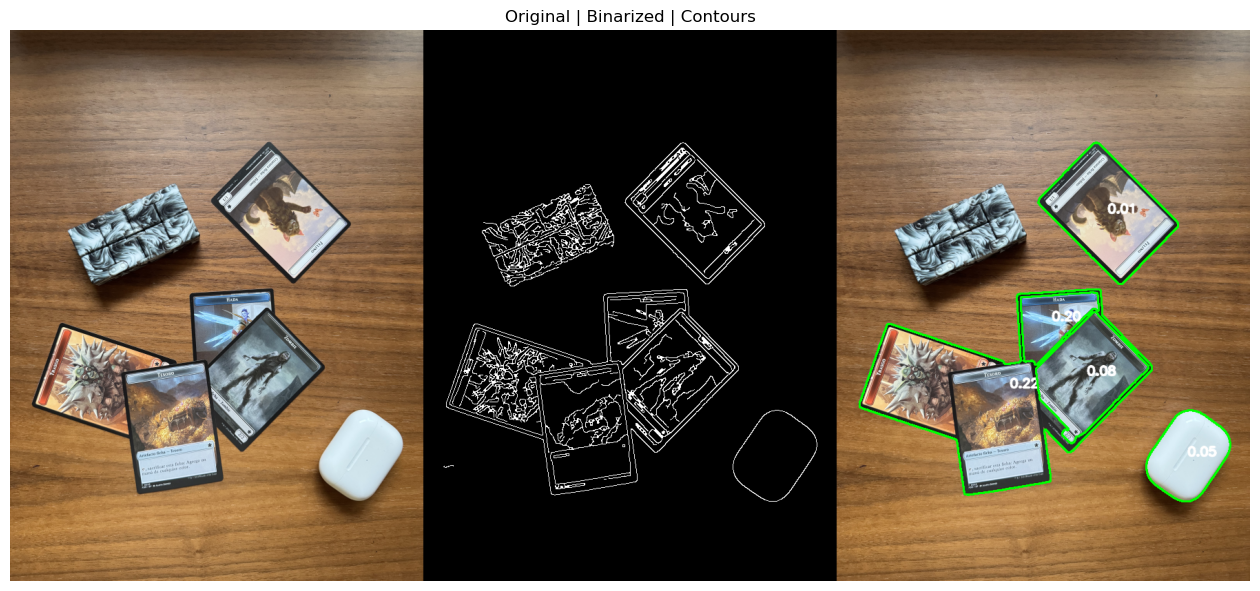

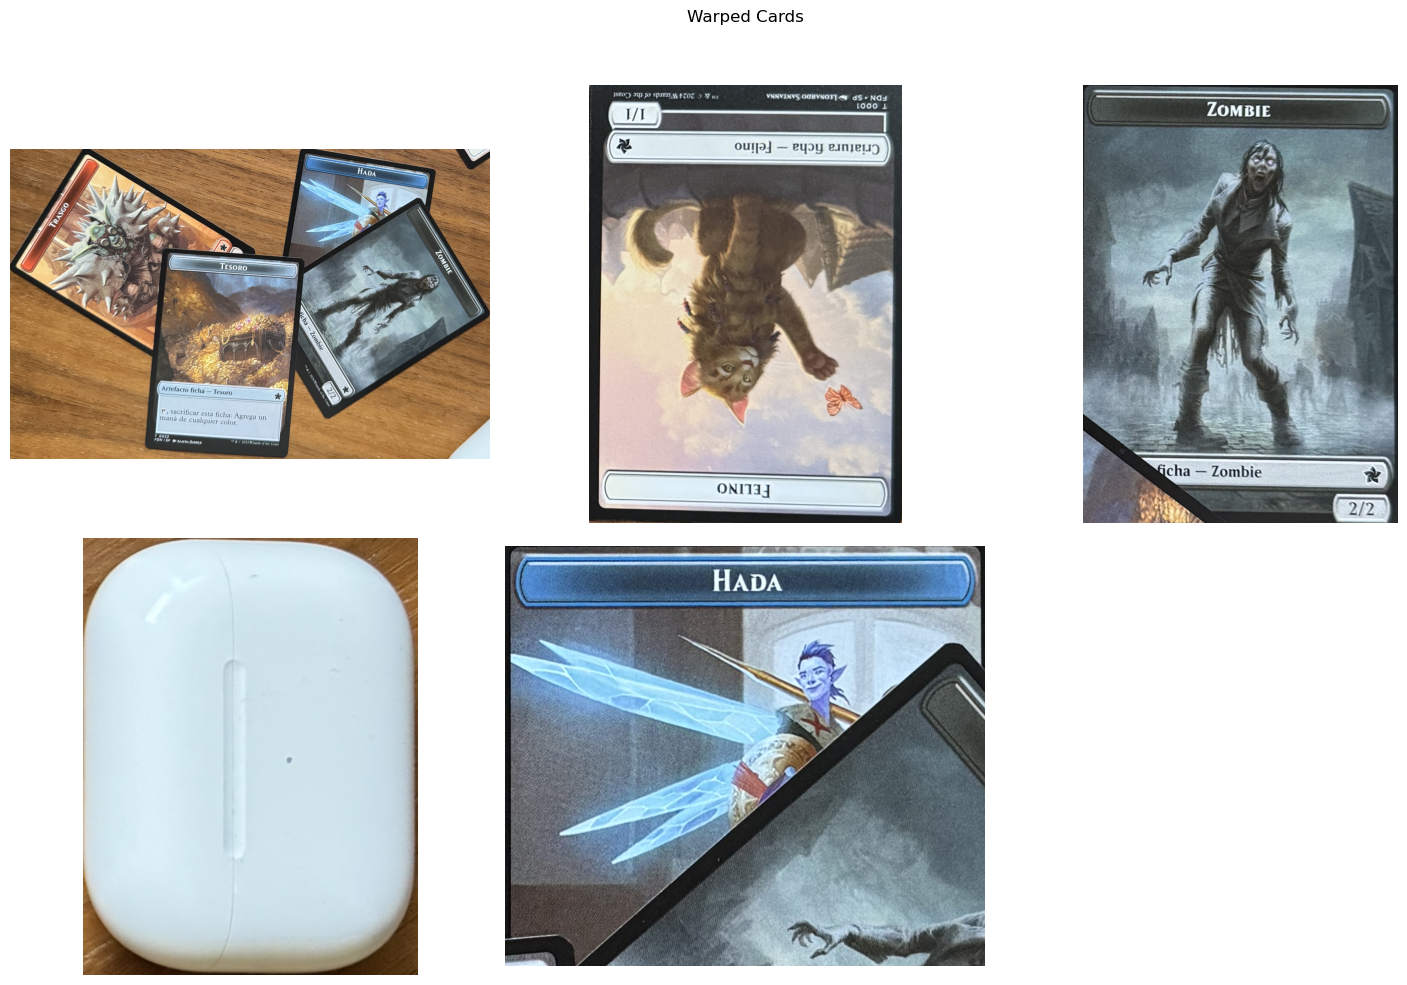

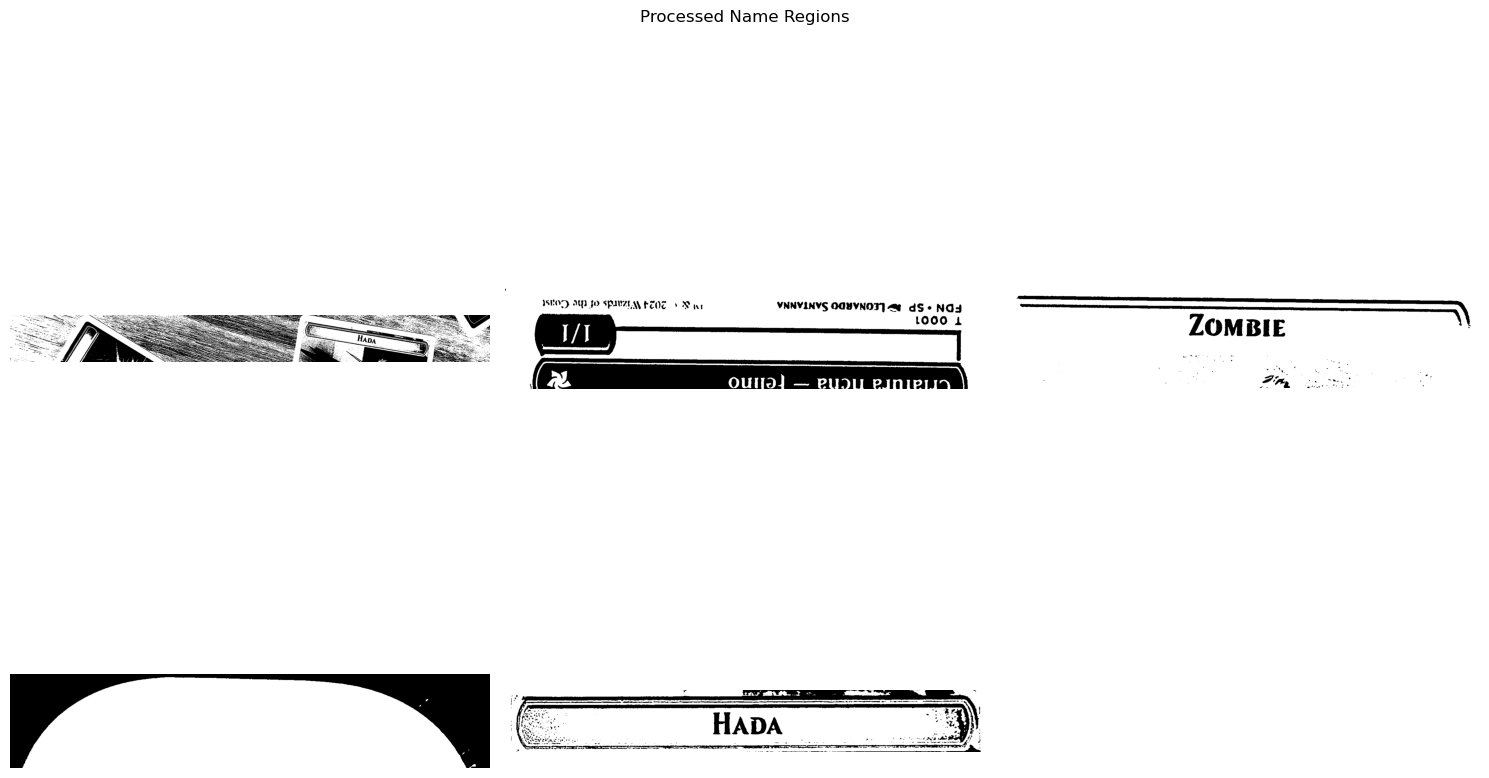

Detected Card Names:
Og pag OO an        ot
She Se aes el. SATSS DERE Sipe ee        ear.     .
s        So TAR A ig    TSS         SS ee erate SAT ee   Sa ee
   ww es   WS VSS ESN SSN ME ees Sa Ses     ea   OP ey     .                                     2 ae     SSeS     tone oS SI teers SS.              A
-     Js CME ON nn Sere TS mS SAE TA ik- Sst SSS ee VES   SS SS     tS SSN   1 ff                                        Se RE ie niga eee SETS RS         S
    oe ta ae       Te a aS A SESS  ESS   2 SE ES ee Spe eae    Pwo he ne                   ee                             en eee ao Ee       ees
TO SUS a SSS    .    SS     et ST                 SSS SSS           Se SSA SSS SS      - Ss        ee        j   BR pe                                        - ee                                     So Win TEER .      wo OEE
IS    tO ST TBR no            SEES   Ss   P       -           a Ke      a SS   ea      .   el    be 4 eae                                                          

In [7]:
# ---------------------------
# Main Entry Point
# ---------------------------
if __name__ == "__main__":
    model_image = "../data/cards/shape.png"
    input_image = "../data/cards/test-scene-cenital.jpeg"
    shape_preprocess = ImagePreprocessor.preprocessing1
    ocr_preprocess = ImagePreprocessor.preprocessing2
    method = fourier_shape_detection
    visualize_shapes = True
    visualize_names = True
    save_shapes = None

    target_img, found, found_original = find_cards(model_image,
                                                   input_image,
                                                   shape_preprocess,
                                                   method,
                                                   visualize_shapes,
                                                   save_shapes)
    
    card_names = read_card_names_from_found_contours(input_image,
                                                     found_original,
                                                     ocr_preprocess,
                                                     visualize_names)